In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data 

In [10]:
from analysis.analyzers.data_segmenter import DataSegmenter

In [11]:

from analysis.featurizers.ohlcv_to_ohlcv_and_deltas import ohlcv_to_ohlcv_and_deltas

# EXPERIMENTAL PARAMETER
transformation = ohlcv_to_ohlcv_and_deltas

# from analysis.segmenters.recursive_cusum_segmenter import recursive_cusum_segmenter
# from analysis.segmenters.cusum_segmenter import cusum_segmenter
from analysis.segmenters.striding_segmenter import striding_segmenter_builder

# EXPERIMENTAL PARAMETER
# cusum_threshold = 2.0

# cusum_on_close = lambda data: cusum_segmenter(
#     data,
#     cusum_on=lambda x: x['close'],
#     threshold=cusum_threshold
# )

# EXPERIMENTAL PARAMETERS
length = 10
stride = 8

segmenter = striding_segmenter_builder(
    length=length,
    stride=stride,
)

m: DataSegmenter = DataSegmenter(
    'SPY',
    transformation=transformation,
    segmenter=segmenter,
)

In [12]:
m.load_historical()

### Featurize segments

In [13]:
m.transform_data()

#### Segmentation

In [15]:
m.segment_data()
m.save_segmented_data()

In [16]:
m.vectorize_segments()

In [17]:
m.vectorized_segments[0]

array([ 4.56225000e+02,  4.56390000e+02,  4.56140000e+02,  4.56285000e+02,
        6.27100000e+03, -1.86276873e-04, -1.97160883e-04,  1.97346782e-04,
        1.64397975e-04,  4.56265000e+02,  4.56535000e+02,  4.56135000e+02,
        4.56515000e+02,  1.35280000e+04,  8.76760370e-05,  3.17710730e-04,
       -1.09615469e-05,  5.04070921e-04,  4.56490000e+02,  4.56520000e+02,
        4.56265000e+02,  4.56365000e+02,  3.27100000e+03,  4.93134472e-04,
       -3.28561885e-05,  2.85003343e-04, -3.28576279e-04,  4.56380000e+02,
        4.56645000e+02,  4.56315000e+02,  4.56615000e+02,  3.83900000e+03,
       -2.40969134e-04,  2.73810567e-04,  1.09585438e-04,  5.47807128e-04,
        4.56625000e+02,  4.56770000e+02,  4.56545000e+02,  4.56740000e+02,
        6.07600000e+03,  5.36833341e-04,  2.73735615e-04,  5.04037781e-04,
        2.73753600e-04,  4.56740000e+02,  4.56800000e+02,  4.56680000e+02,
        4.56770000e+02,  1.08150000e+04,  2.51847796e-04,  6.56785691e-05,
        2.95699219e-04,  

Next up is training. To do this, we first split the data into 70% training, 15% validation, and 15% testing buckets.

In [18]:
from analysis.trainers.trainer import Trainer

trainer = Trainer(m.vectorized_segments)


Data statistics:
Train mean: 0.0000, std: 1.0000
Val mean (after norm): 0.5179, std: 1.6633
Val/Train std ratio: 1.66


In [19]:
trainer.train()

/Users/landho/git/stocks/.direnv/python-3.14/lib/python3.14/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/50, Train Loss: 0.624703, Val Loss: 2.255191
Epoch 2/50, Train Loss: 0.514657, Val Loss: 2.160264
Epoch 3/50, Train Loss: 0.484877, Val Loss: 2.115861
Epoch 4/50, Train Loss: 0.470832, Val Loss: 2.093596
Epoch 5/50, Train Loss: 0.462611, Val Loss: 2.077834
Epoch 6/50, Train Loss: 0.456165, Val Loss: 2.067391
Epoch 7/50, Train Loss: 0.450212, Val Loss: 2.054206
Epoch 8/50, Train Loss: 0.444957, Val Loss: 2.047030
Epoch 9/50, Train Loss: 0.439925, Val Loss: 2.040064
Epoch 10/50, Train Loss: 0.436069, Val Loss: 2.031777
Epoch 11/50, Train Loss: 0.432012, Val Loss: 2.028289
Epoch 12/50, Train Loss: 0.428348, Val Loss: 2.023982
Epoch 13/50, Train Loss: 0.425993, Val Loss: 2.018424
Epoch 14/50, Train Loss: 0.423445, Val Loss: 2.015933
Epoch 15/50, Train Loss: 0.419833, Val Loss: 2.012983
Epoch 16/50, Train Loss: 0.417188, Val Loss: 2.012056
Epoch 17/50, Train Loss: 0.415002, Val Loss: 2.008693
Epoch 18/50, Train Loss: 0.412662, Val Loss: 2.009048
Epoch 19/50, Train Loss: 0.409509, Va

# STOP HERE

In [ ]:
import pandas as pd
import numpy as np

def interpolate_close_and_volume_to_fixed_size(data, target_size=1000):
    """Interpolate segment to fixed size preserving temporal relationships"""
    if len(data) == target_size:
        return data
    
    # Create interpolation indices
    original_indices = np.linspace(0, 1, len(data))
    target_indices = np.linspace(0, 1, target_size)
    
    scaled_data = {}
    scaled_data["close"] = np.interp(
        target_indices, 
        original_indices, 
        data["close"].values
    )

    scale_factor = len(target_indices) / len(original_indices)

    # Subdivide volume by dividing each original volume by the scale factor
    scaled_data["volume"] = np.interp(
        target_indices, 
        original_indices, 
        data["volume"].values
    ) / scale_factor

    return pd.DataFrame(scaled_data)

In [ ]:
test = m.segments[0]
# print(test)
# print(test["close", "volume"])
interpolatable_test = test[["close", "volume"]]
interpolated_segment = interpolate_close_and_volume_to_fixed_size(test, target_size=1000)

In [ ]:
# EXPERIMENTAL PARAMETER
normalized_regime_length = 1000
normalized_length_segments = pd.array([
    interpolate_close_and_volume_to_fixed_size(segment, target_size=normalized_regime_length) for segment in m.segments
])

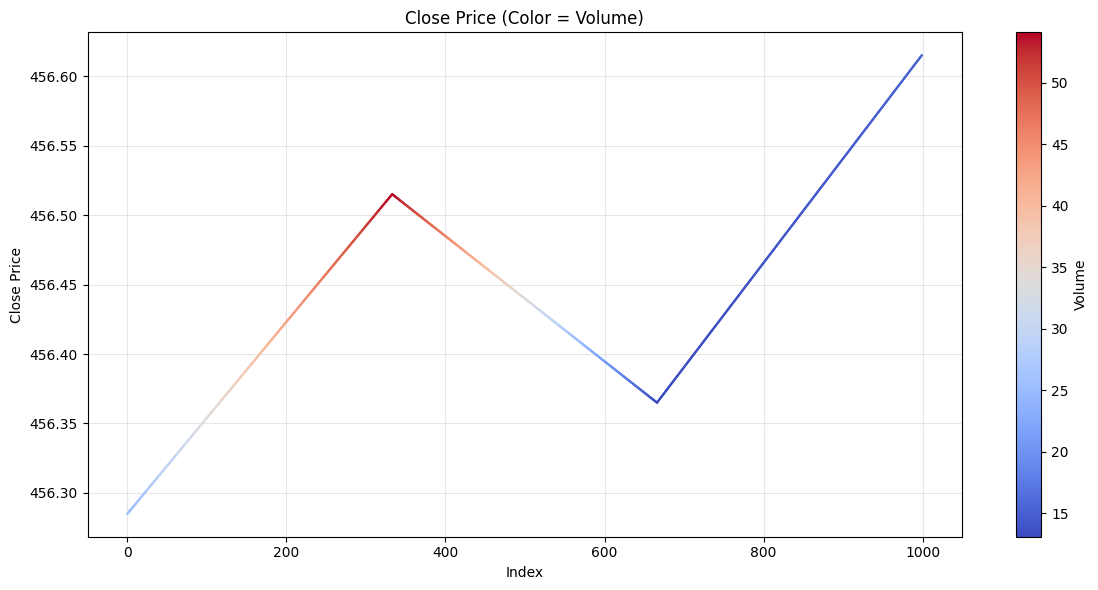

In [ ]:
from analysis.visualizers.visualize_ohlcv_segment import visualize_scaled_close_and_volume_segment
test = normalized_length_segments[0]
visualize_scaled_close_and_volume_segment(test)

In [ ]:
# Now we want to cluster the normalized_length_segments

from analysis.categorizers.gaussian_mixtures import GaussianMixtureCategorizer

categorizer = GaussianMixtureCategorizer()

list_of_normalized_segments = np.array([
    segment.values.flatten() for segment in normalized_length_segments
])


In [ ]:
print(list_of_normalized_segments[0])

[456.285       25.084      456.28569069 ...  15.34917718 456.615
  15.356     ]


In [ ]:

categorizer.data = list_of_normalized_segments

labels = categorizer.categorize()

(1000, 2)


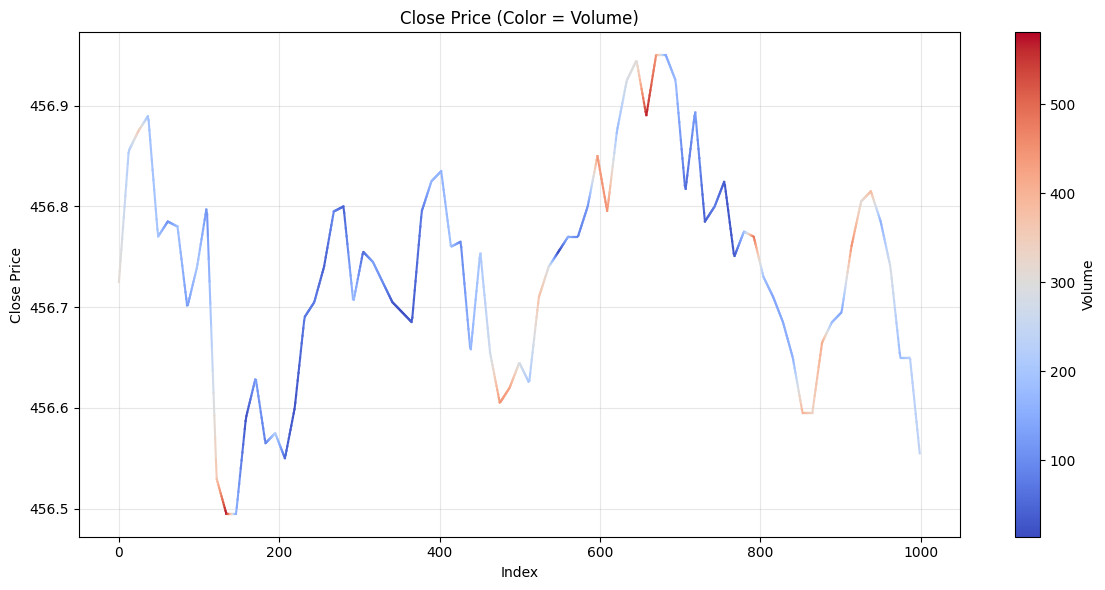

In [ ]:
# print(labels)


label_indices_map = {}
for i, label in enumerate(labels):
    if label not in label_indices_map:
        label_indices_map[label] = []
    label_indices_map[label].append(i)

# for label, indices in label_indices_map.items():
    # print(f"Label {label}: {len(indices)} segments")

# Examine number 7:

index_of_first_in_seven = label_indices_map[7][7]
test_close_and_volume = normalized_length_segments[index_of_first_in_seven]

print(np.shape(test_close_and_volume))

visualize_scaled_close_and_volume_segment(test_close_and_volume)

# for i in label_indices_map[7]:
    
#     visualize_scaled_close_and_volume_segment(i)

In [ ]:
categorizer.get_classification_stats()

{'n_clusters': 10,
 'cluster_sizes': {np.int64(0): np.int64(1483),
  np.int64(1): np.int64(1639),
  np.int64(2): np.int64(1737),
  np.int64(3): np.int64(1837),
  np.int64(4): np.int64(1378),
  np.int64(5): np.int64(1478),
  np.int64(6): np.int64(761),
  np.int64(7): np.int64(892),
  np.int64(8): np.int64(1334),
  np.int64(9): np.int64(1789)},
 'avg_cluster_size': np.float64(1432.8),
 'cluster_size_std': np.float64(344.4444222222215),
 'avg_confidence': np.float64(0.999998615815006),
 'min_confidence': np.float64(0.9903521742063138),
 'low_confidence_pct': np.float64(0.0),
 'silhouette_score': 0.2101796526439305,
 'bic_score': np.float64(-2884550.9399667787),
 'aic_score': np.float64(-3187417.9074548944)}